In [1]:
import sys
sys.path.append('../../../st-mcmc-cme/examples/inflammation')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from il1beta_model import Il1bModel as Model
from ipywidgets import interact, interactive, IntSlider
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Times']})
rc('text', usetex=True)
sns.set(style='darkgrid')


[  14   18   26   42   74  138  266  522 1034 2058]


In [2]:
stmc_tuned = np.load('il1b_mcmc_tuned.npz')
stmc_bridge = np.load('il1b_mcmc_bridge.npz')
stmc_full = np.load('il1b_mcmc_full.npz')
stmc_multi = np.load('il1b_mcmc_multifi.npz')

In [3]:
methods = ['full', 'bridge', 'multi', 'tuned']
method_names = ['Full-fidelity', 'ESS-Bridge', 'IT-Bridge', 'Tuned IT-Bridge']
par_names = ['r_1', 'r_2', 'k_{{01}}', 'a_{{10}}', 'b_{{10}}', 'k_{{12}}', 'k_{{21}}', '\\alpha_1', '\\alpha_2', '\\gamma', 'T_0']
method_colors = ['Red', 'Orange', 'DarkGreen', 'Magenta']
method_ls = ['--', ':', '-', 'dotted']

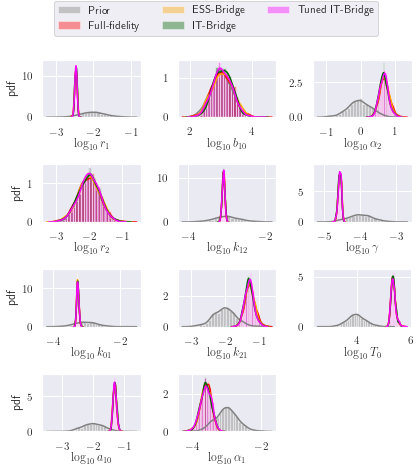

In [4]:
fig, axs = plt.subplots(4, 3)
fig.set_size_inches(6, 6)
fig.set_tight_layout(True)
for ispec in range(0, 3):
    for jpar in range(0, 4):
        ipar = ispec*4 + jpar
        if ipar >= 11:
            break
        thetas = eval(f'stmc_{methods[0]}["theta"]')
        sns.distplot(thetas[:, ipar, 0], ax=axs[jpar, ispec], color='grey', label='Prior')
        for imeth in range(0, len(methods)):
            thetas = eval(f'stmc_{methods[imeth]}["theta"]')
            sns.distplot(thetas[:, ipar, -1], ax=axs[jpar, ispec], color=method_colors[imeth], label=f'{method_names[imeth]}')            
        axs[jpar, ispec].set_xlabel(f'$\log_{{10}}{par_names[ipar]}$')
        if ispec == 0:
            axs[jpar, ispec].set_ylabel('pdf')
axs[-1,-1].axis('off')
h, l = axs[0,0].get_legend_handles_labels()
fig.legend(h,l, bbox_to_anchor=(0, 1.0, 1, 1), loc='lower center', ncol=3)
fig.savefig('il1b_marginal_posteriors.pdf', bbox_inches='tight')        

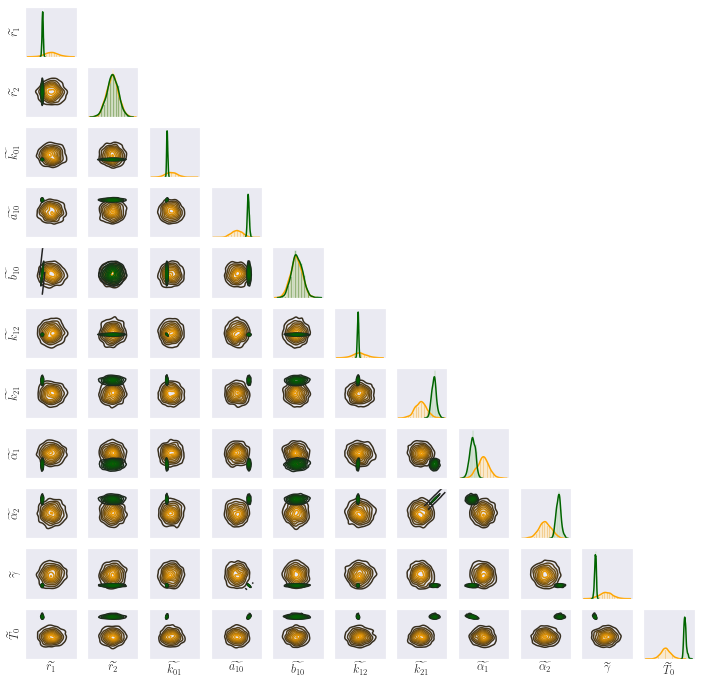

In [35]:
npar = thetas.shape[1]
fig, axes = plt.subplots(npar, npar)
fig.set_size_inches(12,12)
# fig.set_tight_layout(True)
for i in range(0, npar):
    sns.distplot(thetas[:, i, 0], ax=axes[i,i], color='orange')
    sns.distplot(thetas[:, i, -1], ax=axes[i,i], color='darkgreen')
    axes[i,i].get_xaxis().set_ticks([])
    axes[i,i].get_yaxis().set_ticks([])
    if i == 0:
        axes[i,i].set_ylabel(f'$\widetilde{{{par_names[i]}}}$')
    if i == npar-1:
        axes[i,i].set_xlabel(f'$\widetilde{{{par_names[npar-1]}}}$')
    for j in range(0, i):
        axes[i,j].get_xaxis().set_ticks([])
        axes[i,j].get_yaxis().set_ticks([])
#         axes[i,j].scatter(thetas[:,j,0], thetas[:,i,0], color='orange')
#         axes[i,j].scatter(thetas[:,j,-1], thetas[:,i,-1], color='darkgreen')
        sns.kdeplot(thetas[:,j,0], thetas[:,i,0], color='orange', ax=axes[i,j])
        sns.kdeplot(thetas[:,j,-1], thetas[:,i,-1], color='darkgreen', ax=axes[i,j])
        if j == 0:
            axes[i,j].set_ylabel(f'$\widetilde{{{par_names[i]}}}$')
        if i == npar-1:
            axes[i,j].set_xlabel(f'$\widetilde{{{par_names[j]}}}$')
    for j in range(i+1,npar):
        axes[i,j].remove()

1.0
1.7340789159552141
2.2929673031782607
2.023153235258794


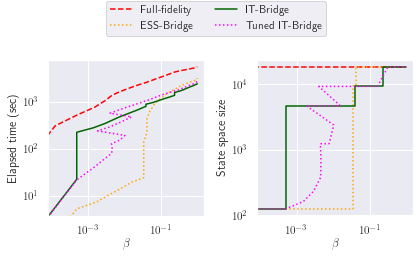

In [6]:


fig, axs = plt.subplots(1, 2)
fig.set_tight_layout(True)
fig.set_size_inches(6, 3)
full_cput = np.max(stmc_full["times"])
for i in range(0, len(methods)):
    beta = eval(f'stmc_{methods[i]}["beta"]')
    cput = eval(f'stmc_{methods[i]}["times"]')
    print(full_cput/np.max(cput))    
    axs[0].plot(beta, cput, label=method_names[i], color=method_colors[i], linestyle=method_ls[i] )
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_xlabel('$\\beta$')
    axs[0].set_ylabel('Elapsed time (sec)')
    
for i in range(0, len(methods)):
    beta = eval(f'stmc_{methods[i]}["beta"]')
    if methods[i] == 'full':
        modelsizes = 9*np.product(Model.copymaxs[-1], axis=0)*np.ones((len(beta),))
    else:
        modelids = np.array(eval(f'stmc_{methods[i]}["modelused"]'), dtype=int)
        modelsizes = 9*Model.copymaxs[modelids]
    
    axs[1].plot(beta, modelsizes, label=method_names[i], color=method_colors[i], linestyle=method_ls[i] )
    axs[1].set_yscale('log')
    axs[1].set_xlabel('$\\beta$')
    axs[1].set_ylabel('State space size')
    axs[1].set_xscale('log')

h, l = axs[1].get_legend_handles_labels()
fig.legend(h,l,bbox_to_anchor=(0, 1, 1, 1), loc = 'lower center', ncol=2)
fig.savefig('il1b_performance.pdf', bbox_inches='tight')

In [7]:
print(25485.07361483574/3600)
print(30917/3600)
43/8.5

7.07918711523215
8.588055555555556


5.0588235294117645

In [8]:
f = open('il1b_pos.tex', mode='w')

f.write('\\begin{tabular}')
f.write('{l')
f.write('|r|')
for jmeth in range(0, len(methods)):
    f.write('r')
f.write('} \n')

f.write('\\toprule')

f.write('\makecell[c]{Parameter}& \makecell[c]{Prior} & \multicolumn{4}{c}{Posterior} \\\\&') 
for jmeth in range(0, len(methods)):
    f.write(f'& {method_names[jmeth]}')
f.write(f'\\\\ \n')    

f.write('\\hline')

for ipar in range(0, 11):
    f.write(f'$\log_{{10}}({par_names[ipar]})$ ')
    f.write(f'& ${Model.prior_mean[ipar] : 3.2f} \\pm {Model.prior_std : 3.2f}$')
    for jmeth in range(0, len(methods)):
        thetas = eval(f'stmc_{methods[jmeth]}["theta"][:,ipar,-1]')
        mean = np.mean(thetas)
        std = np.std(thetas)
        f.write(f' & $ \\text{{{mean:4.2f}}} \\pm {std:3.2f}$ ')
    f.write('\\\\ \n')
f.write('\\bottomrule')    
f.write('\end{tabular}')
f.close()

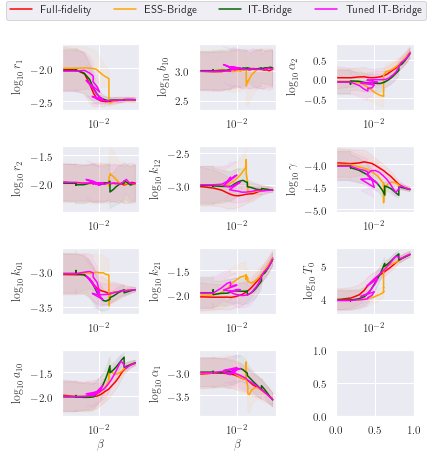

In [9]:
for imeth in range(0, len(methods)):
    betas = eval(f'stmc_{methods[imeth]}["beta"]')
    thetas = eval(f'stmc_{methods[imeth]}["theta"]')
    mus = np.mean(thetas, axis=0)
    stds = np.std(thetas, axis=0)
    exec(f'betas_{methods[imeth]} = betas')
    exec(f'mus_{methods[imeth]} = mus')
    exec(f'stds_{methods[imeth]} = stds')

fig, axs = plt.subplots(4,3)
fig.set_size_inches(6, 6)
fig.set_tight_layout(True)
par_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for ipar in par_to_plot:
    iax = ipar % 4
    jax = ipar // 4
    for imeth in range(0, len(methods)):
        axs[iax, jax].plot(eval(f'betas_{methods[imeth]}'),
                           eval(f'mus_{methods[imeth]} [{ipar}, :]'), 
                           color=method_colors[imeth], 
                           label=method_names[imeth])
        axs[iax, jax].fill_between(eval(f'betas_{methods[imeth]}'),
                           eval(f'mus_{methods[imeth]}[{ipar}, :] + stds_{methods[imeth]}[{ipar}, :]'), 
                           eval(f'mus_{methods[imeth]}[{ipar}, :] - stds_{methods[imeth]}[{ipar}, :]'),
                           color=method_colors[imeth], label='', alpha=0.05)
        axs[iax, jax].set_xscale('log')
        axs[iax, jax].set_ylabel(f'$\log_{{10}}{par_names[ipar]}$')
        if iax == 3:
            axs[iax, jax].set_xlabel('$\\beta$')

h, l = axs[0,0].get_legend_handles_labels()
fig.legend(h,l,bbox_to_anchor=(0, 1, 1, 1), loc = 'lower center', ncol=4)
fig.savefig('il1b_evolution.pdf', bbox_inches='tight')        